# Filter UCDP dataset

(Starting from the UCDP dataset already parsed)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

%matplotlib inline

parsed_ucdp_dataset = '../data/parsed/parsed_ucdp.csv'
ucdp_df = pd.read_csv(parsed_ucdp_dataset, index_col='index', encoding='utf-8', compression='gzip')


The variables are the following:
* Year
* Type
    1. State-Based Violence
    2. Non-State Violence
    3. One-Sided Violence
* Country
* Date start
* Date end
* Casualties

In [2]:
def filter_ucdp(ucdp_df, type_conflict=1, number_casualties='low',
    classification_casualties=1, year=2016,
    n_conflicts_per_country=30, consider_all_conflicts=1):
    """ Returns a filtered dataframe in the ucdp_df format
    INPUT:
        type_conflict: Type of conflict (1,2 or 3)
        
        number_casualties: Number of casualties ('low', 'high')
        
        classification_casualties: How to determine if #casualties is low or high
            1 is what we considered when doing the exploratory analysis
            3 divides creates two groups with approx. equal #conflicts each
            
        year: Year that we want to keep
        
        n_conflicts_per_country: Keep the conflicts from countries with a lower #conflicts.
            If 0, then all conflicts are kept and the next variable is ignored.
        
        consider_all_conflicts: if n_conflicts_per_country>0, choose if filtering by:
            n. of conflicts of the type considered (0)
            n. of conflicts of the year considered (1)
            n. of total #conflicts (2)
    """
    filtered_year_df = ucdp_df[ucdp_df['Year'] == year]
    filtered_df = filtered_year_df[filtered_year_df['Type'] == type_conflict]
    if number_casualties == 'low':
        result_df = filtered_df[filtered_df['Casualties'] <= classification_casualties]
    else:
        result_df = filtered_df[filtered_df['Casualties'] > classification_casualties]
    if n_conflicts_per_country:
        if consider_all_conflicts == 0:
            conflicts_per_country = result_df.groupby('Country').count()['Year']
        elif consider_all_conflicts == 1:
            conflicts_per_country = filtered_year_df.groupby('Country').count()['Year']
        else:
            conflicts_per_country = ucdp_df.groupby('Country').count()['Year']
        countries_kept = list(conflicts_per_country[conflicts_per_country < n_conflicts_per_country].index)
        result_df = result_df[result_df['Country'].isin(countries_kept)]
    return result_df

In [3]:
#### Interesting combinations of parameters (from least to most interesting IMO)
## I prefer the ones with high number of casualties and type 3

# Type 2
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=2, number_casualties='high', classification_casualties=1, year=2016, n_conflicts_per_country=10, consider_all_conflicts=0)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=2, number_casualties='high', classification_casualties=1, year=2015, n_conflicts_per_country=10, consider_all_conflicts=0)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=2, number_casualties='low', classification_casualties=1, year=2016, n_conflicts_per_country=100, consider_all_conflicts=1)
# Type 1
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=1, number_casualties='high', classification_casualties=1, year=2016, n_conflicts_per_country=4, consider_all_conflicts=0) # n_conflicts_per_country=5 is good too
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=1, number_casualties='high', classification_casualties=1, year=2015, n_conflicts_per_country=5, consider_all_conflicts=0)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=1, number_casualties='low', classification_casualties=1, year=2015, n_conflicts_per_country=30, consider_all_conflicts=1)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=1, number_casualties='low', classification_casualties=1, year=2016, n_conflicts_per_country=20, consider_all_conflicts=1)
# Type 3
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=3, number_casualties='low', classification_casualties=1, year=2015, n_conflicts_per_country=60, consider_all_conflicts=1)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=3, number_casualties='low', classification_casualties=1, year=2015, n_conflicts_per_country=6, consider_all_conflicts=0)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=3, number_casualties='high', classification_casualties=1, year=2016, n_conflicts_per_country=36, consider_all_conflicts=1)
filtered_ucdp_df = filter_ucdp(ucdp_df, type_conflict=3, number_casualties='high', classification_casualties=1, year=2016, n_conflicts_per_country=4, consider_all_conflicts=0)


#### Plot some info about the chosen subset
I've been using this to make sure that the `n_conflicts_per_country` and `consider_all_conflicts` variables resulted in a _reasonable_ number of conflicts and countries: around 30 conflicts for around 10 countries is what I went for.

In [4]:
print('Number of conflicts: {}'.format(len(filtered_ucdp_df)))
print('Number of countries: {}'.format(len(filtered_ucdp_df['Country'].unique())))
print('List of countries: {}'.format(filtered_ucdp_df['Country'].unique()))

Number of conflicts: 24
Number of countries: 16
List of countries: ['TD' 'ML' 'FR' 'EG' 'TH' 'MZ' 'CI' 'PH' 'BD' 'LB' 'IL' 'DE' 'CO' 'SA' 'BF'
 'BE']


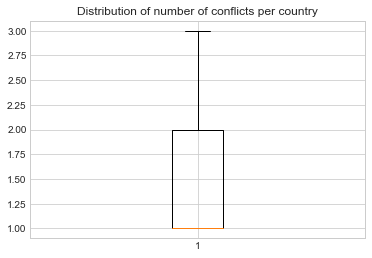

In [5]:
plt.boxplot(filtered_ucdp_df.groupby('Country').count()['Year'])
plt.title('Distribution of number of conflicts per country')
plt.show()

In [6]:
filtered_ucdp_df

,Year,Type,Conflict Name,Date Start,Date End,Casualties,Country
index,,,,,,,
6086,2016,3,IS - Civilians,2016-01-31,2016-01-31,2,TD
6448,2016,3,Government of Mali - Civilians,2016-01-08,2016-01-08,2,ML
6449,2016,3,Government of Mali - Civilians,2016-12-19,2016-12-21,5,ML
6467,2016,3,IS - Civilians,2016-07-14,2016-07-14,86,FR
7204,2016,3,IS - Civilians,2016-09-20,2016-09-25,5,EG
7215,2016,3,IS - Civilians,2016-12-11,2016-12-11,26,EG
21303,2016,3,Patani insurgents - Civilians,2016-01-18,2016-01-18,2,TH
21316,2016,3,Patani insurgents - Civilians,2016-04-01,2016-04-01,2,TH
21338,2016,3,Patani insurgents - Civilians,2016-09-06,2016-09-06,3,TH
